# Sep 12, 2025: align partitions across conditions

conda env: gt

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import dill as pickle 
from scipy import sparse, stats
from scipy.special import gammaln
import graph_tool.all as gt
from glob import glob
import re 
from tqdm import tqdm
from itertools import combinations
import math
from joblib import Parallel, delayed
import random 
from sklearn.preprocessing import OneHotEncoder

# plotting
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from cycler import cycler
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cm import rainbow


# ignore user warnings
import warnings
warnings.filterwarnings("ignore") #, category=UserWarning)

In [2]:
def get_colorblind_palette(n=20):
    """Return a merged, deduplicated colorblind-safe palette from CUD, Seaborn, and extended sources."""
    base = [
        "#0072B2", "#D55E00", "#009E73", "#CC79A7",
        "#F0E442", "#56B4E9", "#E69F00", "#000000",
        "#999999", "#882255", "#44AA99", "#117733"
    ]
    
    new = [
        "#0173B2", "#DE8F05", "#029E73", "#D55E00",  # D55E00 already in base
        "#CC78BC", "#CA9161", "#FBAFE4", "#949494",
        "#ECE133", "#56B4E9"  # 56B4E9 already in base
    ]
    
    # Deduplicate while preserving order
    seen = set()
    full = base + new
    merged = []
    for color in full:
        if color.lower() not in seen:
            merged.append(color)
            seen.add(color.lower())
    
    return merged[:n]

def setup_mpl(fontsize=7):
    """Configure matplotlib for Illustrator export with Helvetica-style fonts and clean styles."""
    
    CUD_COLORS = get_colorblind_palette()
    
    mpl.rcParams.update({
        # Fonts and layout
        "font.family": "sans-serif",
        "font.sans-serif": ["Arial", "DejaVu Sans"],
        "font.size": fontsize,
        "axes.titlesize": fontsize,
        "axes.labelsize": fontsize,
        "xtick.labelsize": fontsize,
        "ytick.labelsize": fontsize,
        "legend.fontsize": fontsize,

        # Export settings
        "svg.fonttype": 'none',
        "pdf.fonttype": 42,
        "ps.fonttype": 42,
        "figure.dpi": 300,
        "savefig.dpi": 300,
        "text.usetex": False,

        # Axes and ticks
        "axes.linewidth": 0.5,
        "xtick.major.width": 0.5,
        "ytick.major.width": 0.5,
        "xtick.minor.width": 0.5,
        "ytick.minor.width": 0.5,
        "xtick.major.size": 2.5,
        "ytick.major.size": 2.5,

        # Lines
        "lines.linewidth": 1.0,

        # Default color cycle (Color Universal Design)
        "axes.prop_cycle": cycler('color', CUD_COLORS),
    })

    # mpl.rcParams["axes.prop_cycle"] = cycler('color', get_colorblind_palette())

def setup_plotting(palette=None, context="paper", fontsize=7):
    """
    Configure seaborn with 'paper' context and synced matplotlib rcParams.
    """
    setup_mpl(fontsize)

    if palette is None:
        try:
            from cycler import cycler
            cycle = mpl.rcParams['axes.prop_cycle']
            palette = [d['color'] for d in cycle]
        except Exception:
            palette = sns.color_palette("colorblind")

    sns.set_theme(
        context=context,       # use "paper"
        style="white", 
        palette=palette, 
        rc=mpl.rcParams
    )

    setup_mpl(fontsize)

In [3]:
# setup_plotting(context='paper', fontsize=7)
setup_mpl(fontsize=7)
CUD_COLORS = get_colorblind_palette()

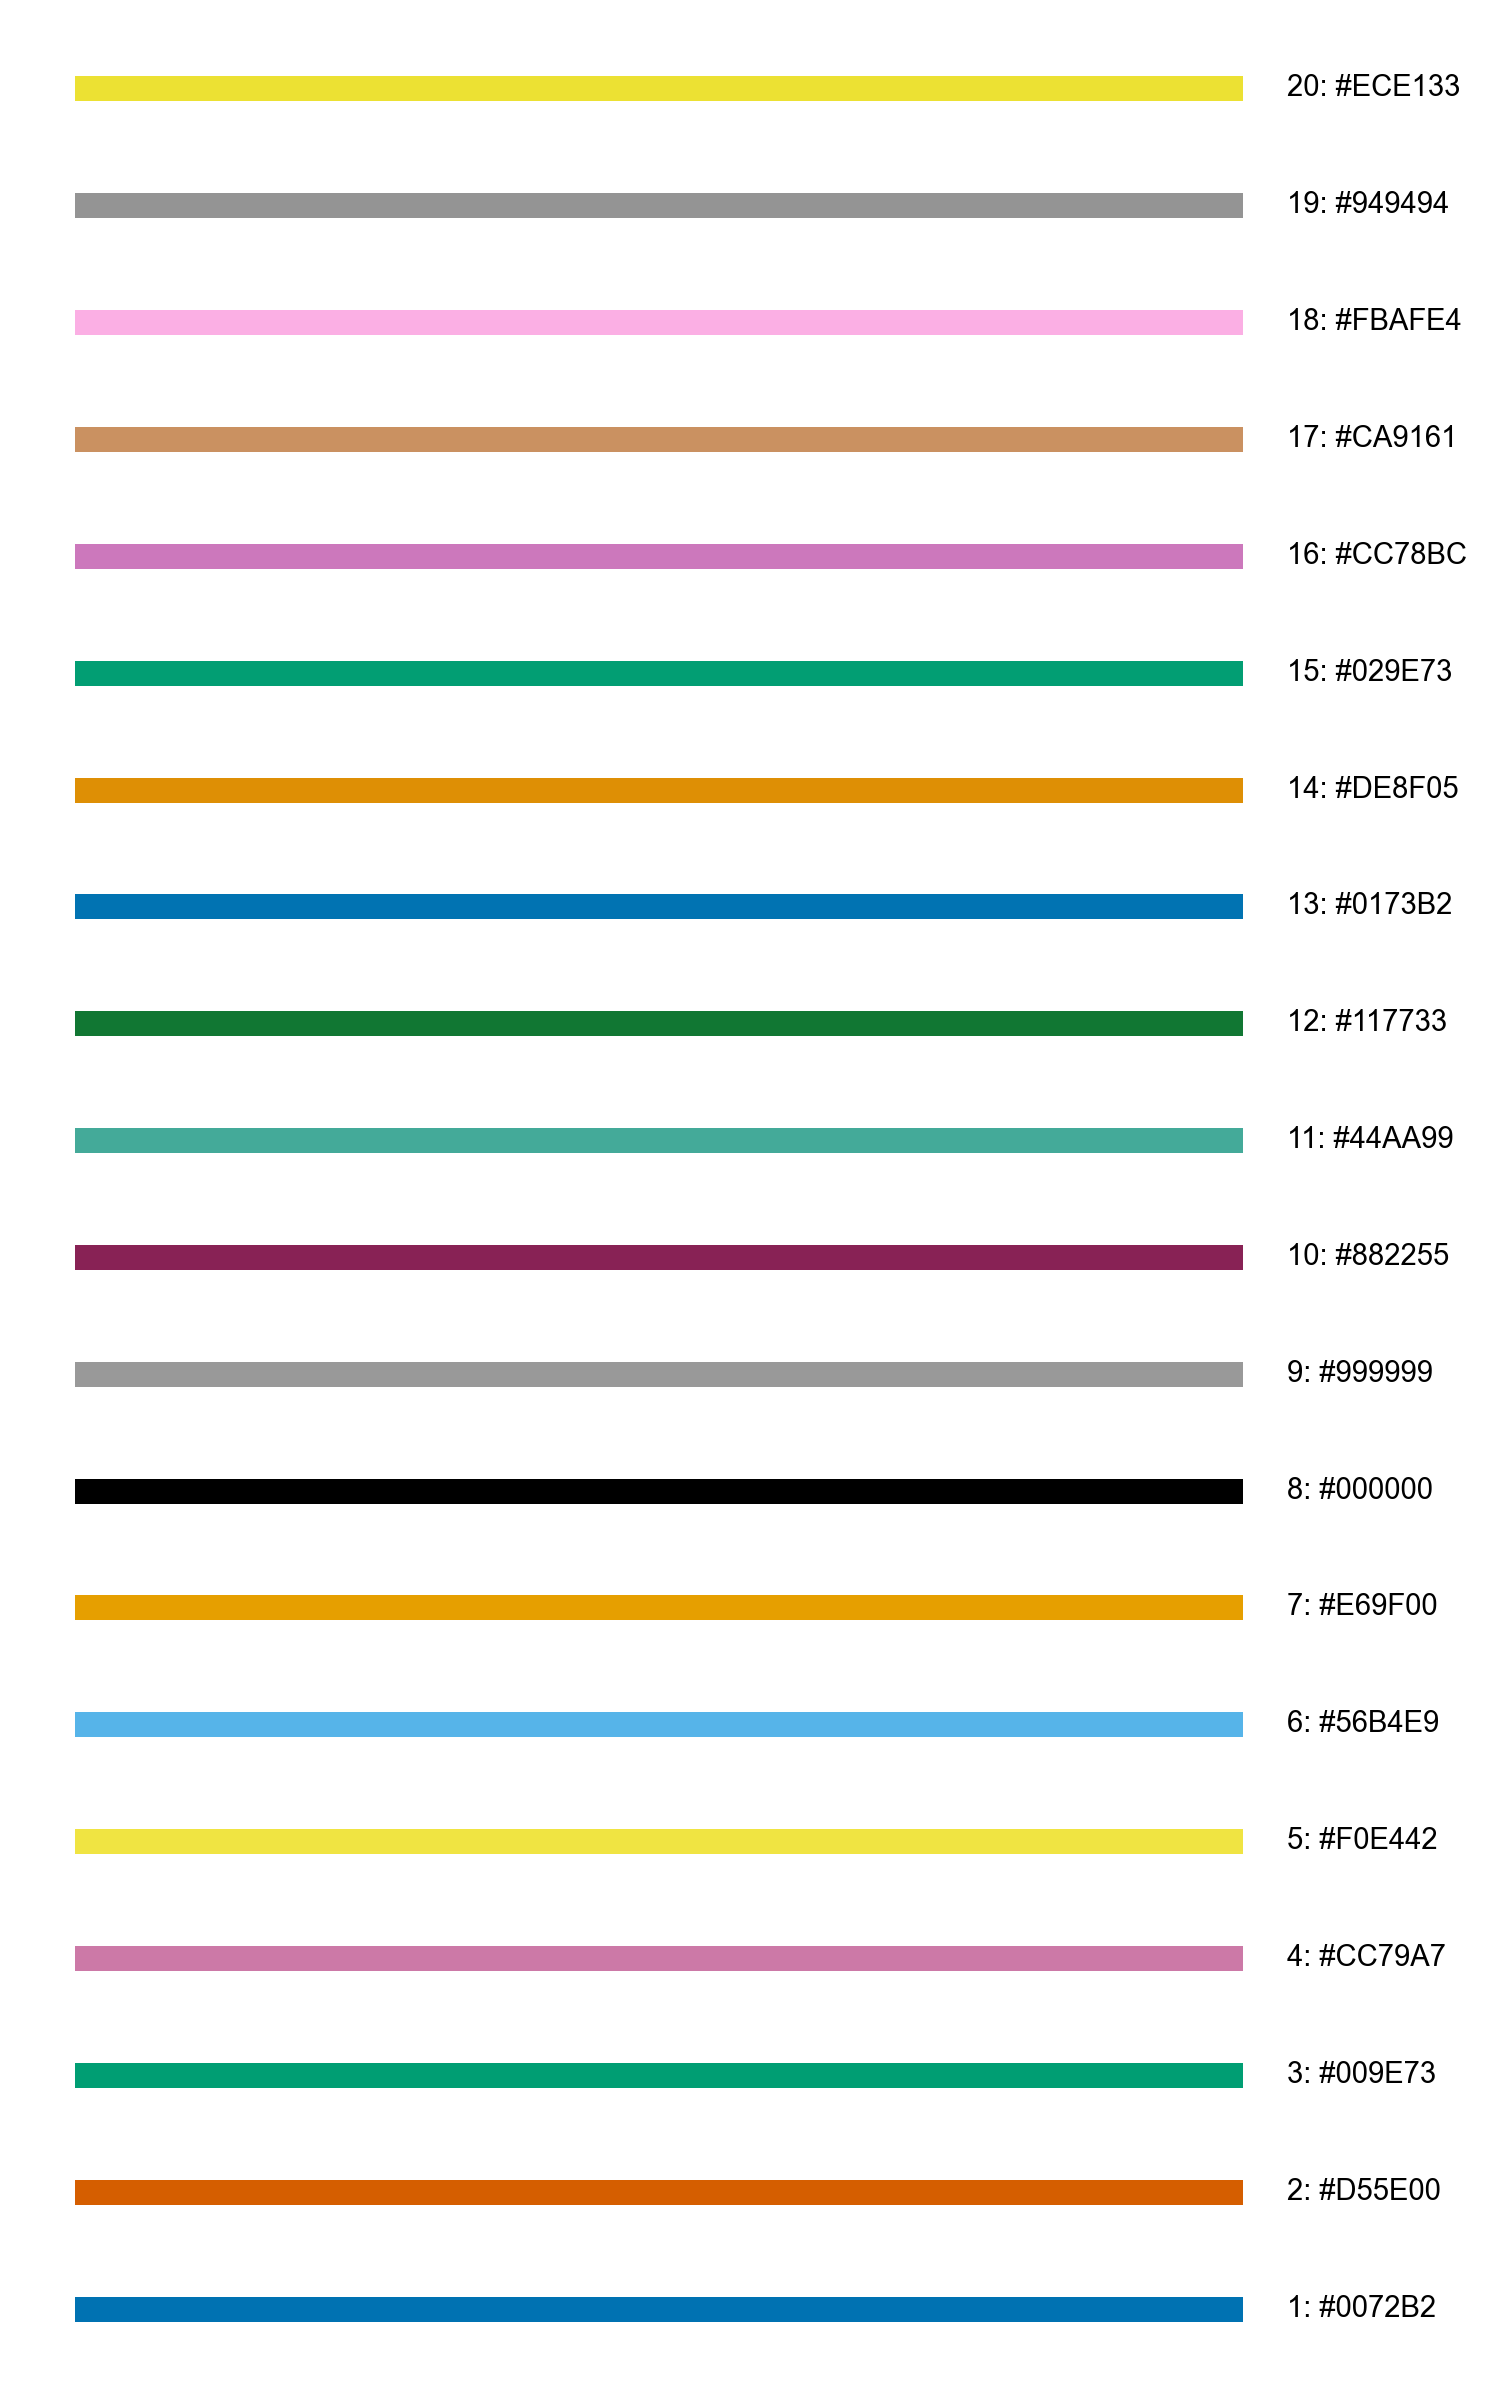

In [4]:
def preview_colorblind_palette():
    colors = get_colorblind_palette()
    n = len(colors)
    
    fig, ax = plt.subplots(figsize=(5, 0.4 * n))
    for i, color in enumerate(colors):
        ax.plot([0, 1], [i, i], color=color, linewidth=6)
        ax.text(1.05, i, f"{i+1}: {color}", va='center', ha='left', fontsize=7)
    
    ax.set_ylim(-0.5, n - 0.5)
    ax.axis('off')
    plt.tight_layout()
    plt.show()

# Call the function
preview_colorblind_palette()

| Color     | HEX       | Use |
|-----------|-----------|-----|
| Blue      | `#0072B2` | Chain 1 |
| Vermilion | `#D55E00` | Chain 2 |
| Green     | `#009E73` | Chain 3 |
| Purple    | `#CC79A7` | Chain 4 |
| Yellow    | `#F0E442` | Chain 5 |
| Light Blue| `#56B4E9` | Chain 6 |
| Orange    | `#E69F00` | Chain 7 |
| Black     | `#000000` | Chain 8 |

In [5]:
class ARGS():
    pass

args = ARGS()

args.SEED = 100

gt.seed_rng(args.SEED)
np.random.seed(args.SEED)

In [6]:
args.ANALYSIS = 'trial-end'
# args.WINDOW = np.arange(5, 8+1)
args.GRAPH_DEF = f'constructed'
args.GRAPH_METHOD = f'pearson'
args.THRESHOLD = f'signed'
args.EDGE_DEF = f'binary'
args.EDGE_DENSITY = 20
args.LAYER_DEF = f'individual'
args.DATA_UNIT = f'grp'

BASE_path = f'/home/govindas/lab-data/aba'
PARC_DESC = f'NEWMAX_ROIs_final_gm_104_2mm' #f'ABA_ROIs_final_gm_36'
ROI_path = (
    f'{BASE_path}/{PARC_DESC}'
)
os.makedirs(ROI_path, exist_ok=True)
TS_path = f'{ROI_path}/roi-timeseries'
os.makedirs(TS_path, exist_ok=True)

ROI_RESULTS_path = (
    f'{ROI_path}'
    f'/analysis-{args.ANALYSIS}'
    f'/graph-{args.GRAPH_DEF}/method-{args.GRAPH_METHOD}'
    f'/threshold-{args.THRESHOLD}/edge-{args.EDGE_DEF}/density-{args.EDGE_DENSITY}'
    f'/layer-{args.LAYER_DEF}/unit-{args.DATA_UNIT}'
)
GRAPH_path = f'{ROI_RESULTS_path}/graphs'
SBM_path = f'{ROI_RESULTS_path}/model-fits'
DIAG_path = f'{ROI_RESULTS_path}/diagnostics_insets'
ESTIM_path = f'{ROI_RESULTS_path}/estimates'
os.makedirs(ESTIM_path, exist_ok=True)

In [7]:
gfile = sorted(glob(f'{GRAPH_path}/*'))[0]
g = gt.load_graph(gfile)
g

<Graph object, undirected, with 104 vertices and 1072 edges, 1 internal edge property, at 0x7fd4d2861550>

In [8]:
args.dc, args.sbm = True, 'a'
args.nested = args.sbm == 'h'

def sbm_name(args):
    dc = f'dc' if args.dc else f'nd'
    dc = f'' if args.sbm in ['a', 'm'] else dc
    file = f'sbm-{dc}-{args.sbm}'
    return file

SBM = sbm_name(args)
SBM

'sbm--a'

In [9]:
indiv_files = sorted(glob(f'{ESTIM_path}/{SBM}/cond-*/partition-modes/*desc-df.pkl', recursive=True))

In [10]:
indiv_files

['/home/govindas/lab-data/aba/NEWMAX_ROIs_final_gm_104_2mm/analysis-trial-end/graph-constructed/method-pearson/threshold-signed/edge-binary/density-20/layer-individual/unit-grp/estimates/sbm--a/cond-PLAY_highR/partition-modes/sbm--a_desc-df.pkl',
 '/home/govindas/lab-data/aba/NEWMAX_ROIs_final_gm_104_2mm/analysis-trial-end/graph-constructed/method-pearson/threshold-signed/edge-binary/density-20/layer-individual/unit-grp/estimates/sbm--a/cond-PLAY_highT/partition-modes/sbm--a_desc-df.pkl',
 '/home/govindas/lab-data/aba/NEWMAX_ROIs_final_gm_104_2mm/analysis-trial-end/graph-constructed/method-pearson/threshold-signed/edge-binary/density-20/layer-individual/unit-grp/estimates/sbm--a/cond-PLAY_lowR/partition-modes/sbm--a_desc-df.pkl',
 '/home/govindas/lab-data/aba/NEWMAX_ROIs_final_gm_104_2mm/analysis-trial-end/graph-constructed/method-pearson/threshold-signed/edge-binary/density-20/layer-individual/unit-grp/estimates/sbm--a/cond-PLAY_lowT/partition-modes/sbm--a_desc-df.pkl']

In [11]:
indests_df = []
for indiv_file in tqdm(indiv_files):
    with open(indiv_file, 'rb') as f:
        df = pickle.load(f)
    
    indests_df += [df]
indests_df = pd.concat(indests_df).reset_index(drop=True)
indests_df

100%|██████████| 4/4 [01:42<00:00, 25.69s/it]


,cond,sbm,mode_id,mode,pi,omega,sigma
0,PLAY_highR,sbm--a,0,<graph_tool.inference.partition_modes.Partitio...,"[[0.0, 0.985516405961974, 0.014483594038026017...",0.253363,0.025277
1,PLAY_highR,sbm--a,1,<graph_tool.inference.partition_modes.Partitio...,"[[0.0, 0.9872134546711209, 0.01278654532887916...",0.115839,0.050446
2,PLAY_highR,sbm--a,2,<graph_tool.inference.partition_modes.Partitio...,"[[0.0, 0.9685773904504725, 0.03142260954952743...",0.108714,0.044634
3,PLAY_highR,sbm--a,3,<graph_tool.inference.partition_modes.Partitio...,"[[0.0, 0.9896556239361005, 0.01034437606389943...",0.101908,0.034222
4,PLAY_highR,sbm--a,4,<graph_tool.inference.partition_modes.Partitio...,"[[0.0, 0.9651193286126409, 0.03488067138735903...",0.101761,0.056444
5,PLAY_highR,sbm--a,5,<graph_tool.inference.partition_modes.Partitio...,"[[0.0, 0.967537770518579, 0.03246222948142099]...",0.065359,0.091136
6,PLAY_highR,sbm--a,6,<graph_tool.inference.partition_modes.Partitio...,"[[0.0, 0.9679778113968734, 0.03202218860312657...",0.052922,0.069693
7,PLAY_highR,sbm--a,7,<graph_tool.inference.partition_modes.Partitio...,"[[0.0, 0.9867888918846051, 0.01321110811539498...",0.049493,0.059450
8,PLAY_highR,sbm--a,8,<graph_tool.inference.partition_modes.Partitio...,"[[0.0, 1.0], [0.0, 1.0], [0.003311258278145695...",0.036269,0.024997
9,PLAY_highR,sbm--a,9,<graph_tool.inference.partition_modes.Partitio...,"[[0.0, 0.938375350140056, 0.06162464985994398]...",0.023819,0.121897


In [12]:
conds = indests_df['cond'].unique()
groups = [(cond, group) for (cond, group) in indests_df.groupby(by='cond')]

In [13]:
[np.exp(stats.entropy(group[1]['omega'])) for group in groups]

[np.float64(10.810599012663355),
 np.float64(8.208631177373968),
 np.float64(1.1730598556831788),
 np.float64(7.985260359387697)]

<Axes: xlabel='mode_id', ylabel='omega'>

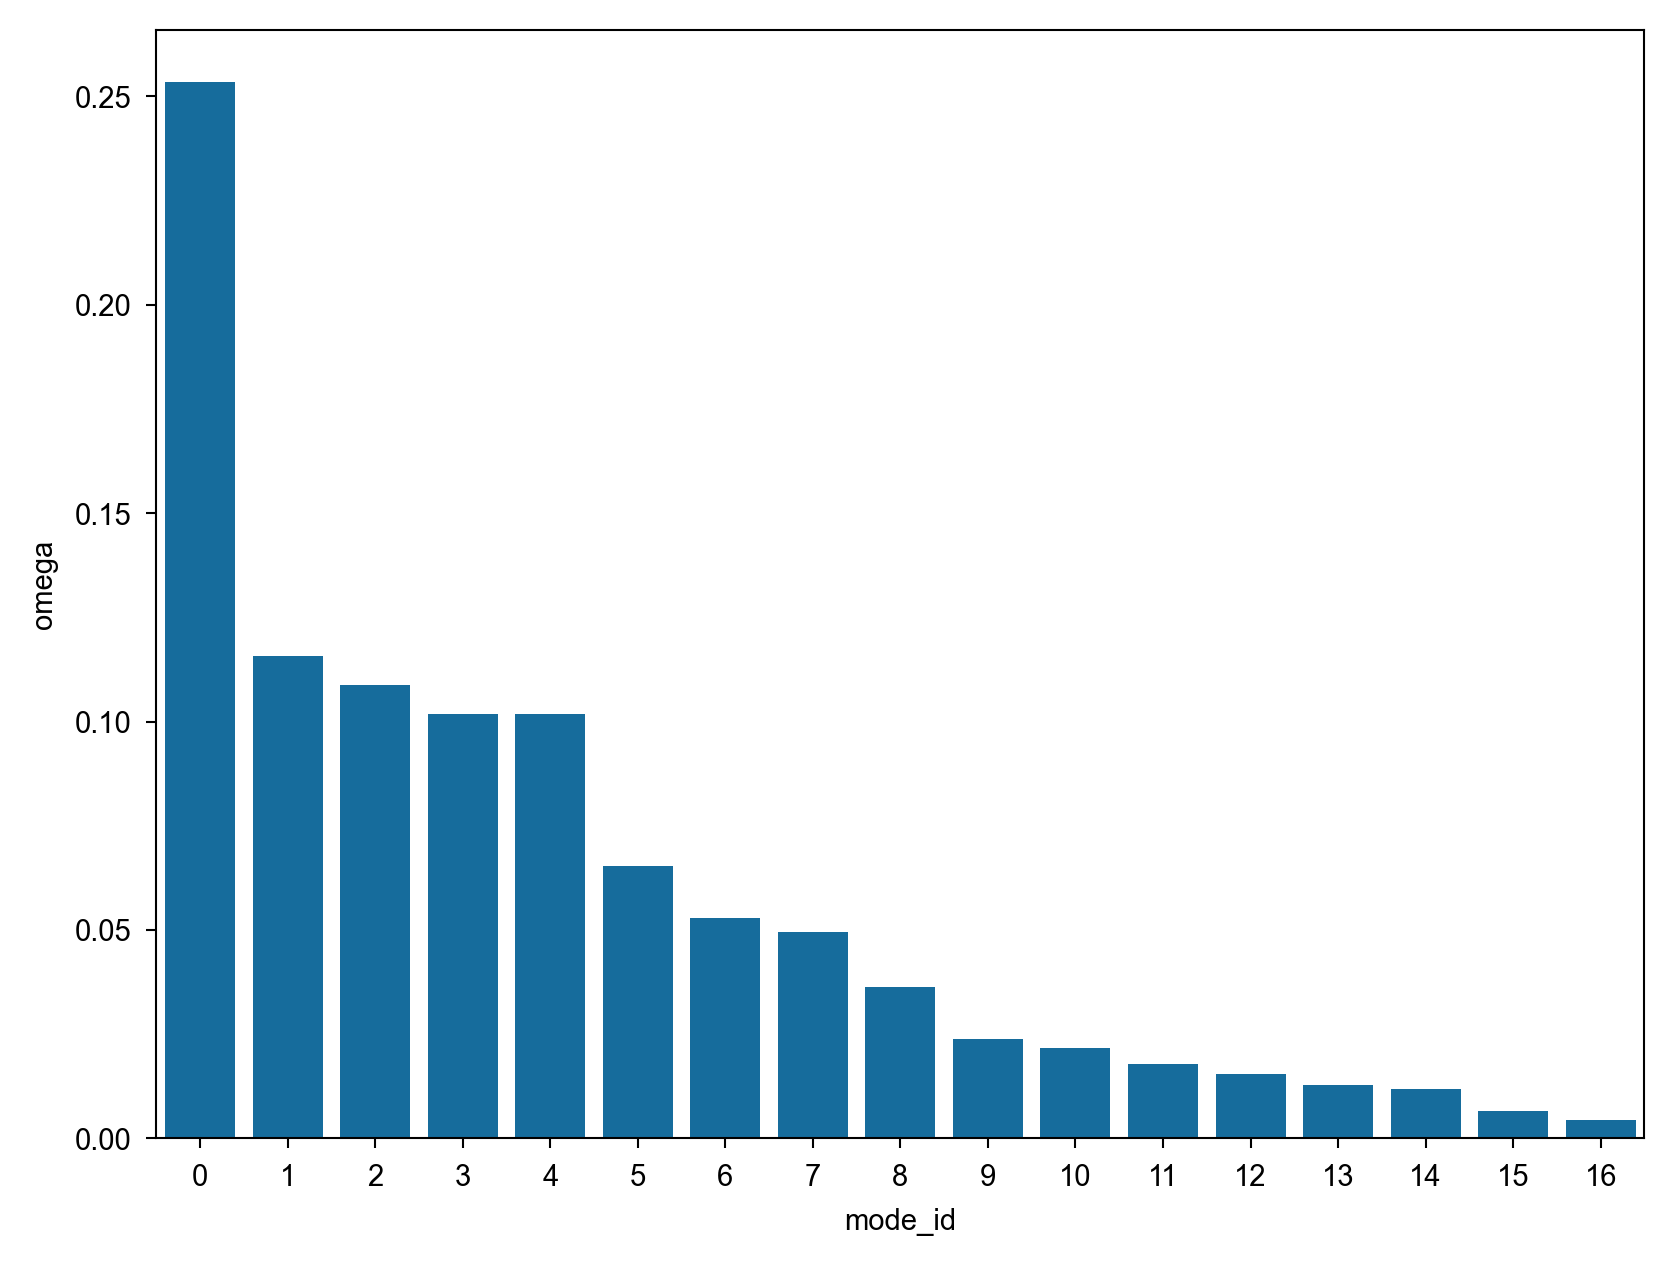

In [14]:
sns.barplot(groups[0][1], y='omega', x='mode_id')

In [15]:
def get_membership_matrix(args, df, col='pi'):
    num_modes = len(df)
    num_comms = np.max(df[col].apply(lambda pi: pi.shape[-1]))
    num_rois = df.iloc[0][col].shape[0]
    M = np.zeros((num_rois, num_modes, num_comms)) # membership profile matrix

    for idx_mode in range(num_modes):
        pi = df.iloc[idx_mode][col]
        M[:, idx_mode, :pi.shape[-1]] = pi
    return M

In [16]:
soft_df = []
for cond, group in indests_df.groupby('cond'):
    M = get_membership_matrix(args, group)
    omegas = group['omega'].to_list()
    X = np.average(M, axis=1, weights=omegas)
    soft_df += [pd.DataFrame(dict(
        cond=[cond],
        soft_comm=[X],
    ))]
soft_df = pd.concat(soft_df).reset_index(drop=True)
soft_df

,cond,soft_comm
0,PLAY_highR,"[[0.0, 0.9744462236455832, 0.02555377635441686..."
1,PLAY_highT,"[[0.0, 0.968454048285981, 0.03154595171401895,..."
2,PLAY_lowR,"[[0.9936120557444822, 6.668000266720011e-05, 0..."
3,PLAY_lowT,"[[0.00998866439954658, 0.9833433353337336, 0.0..."


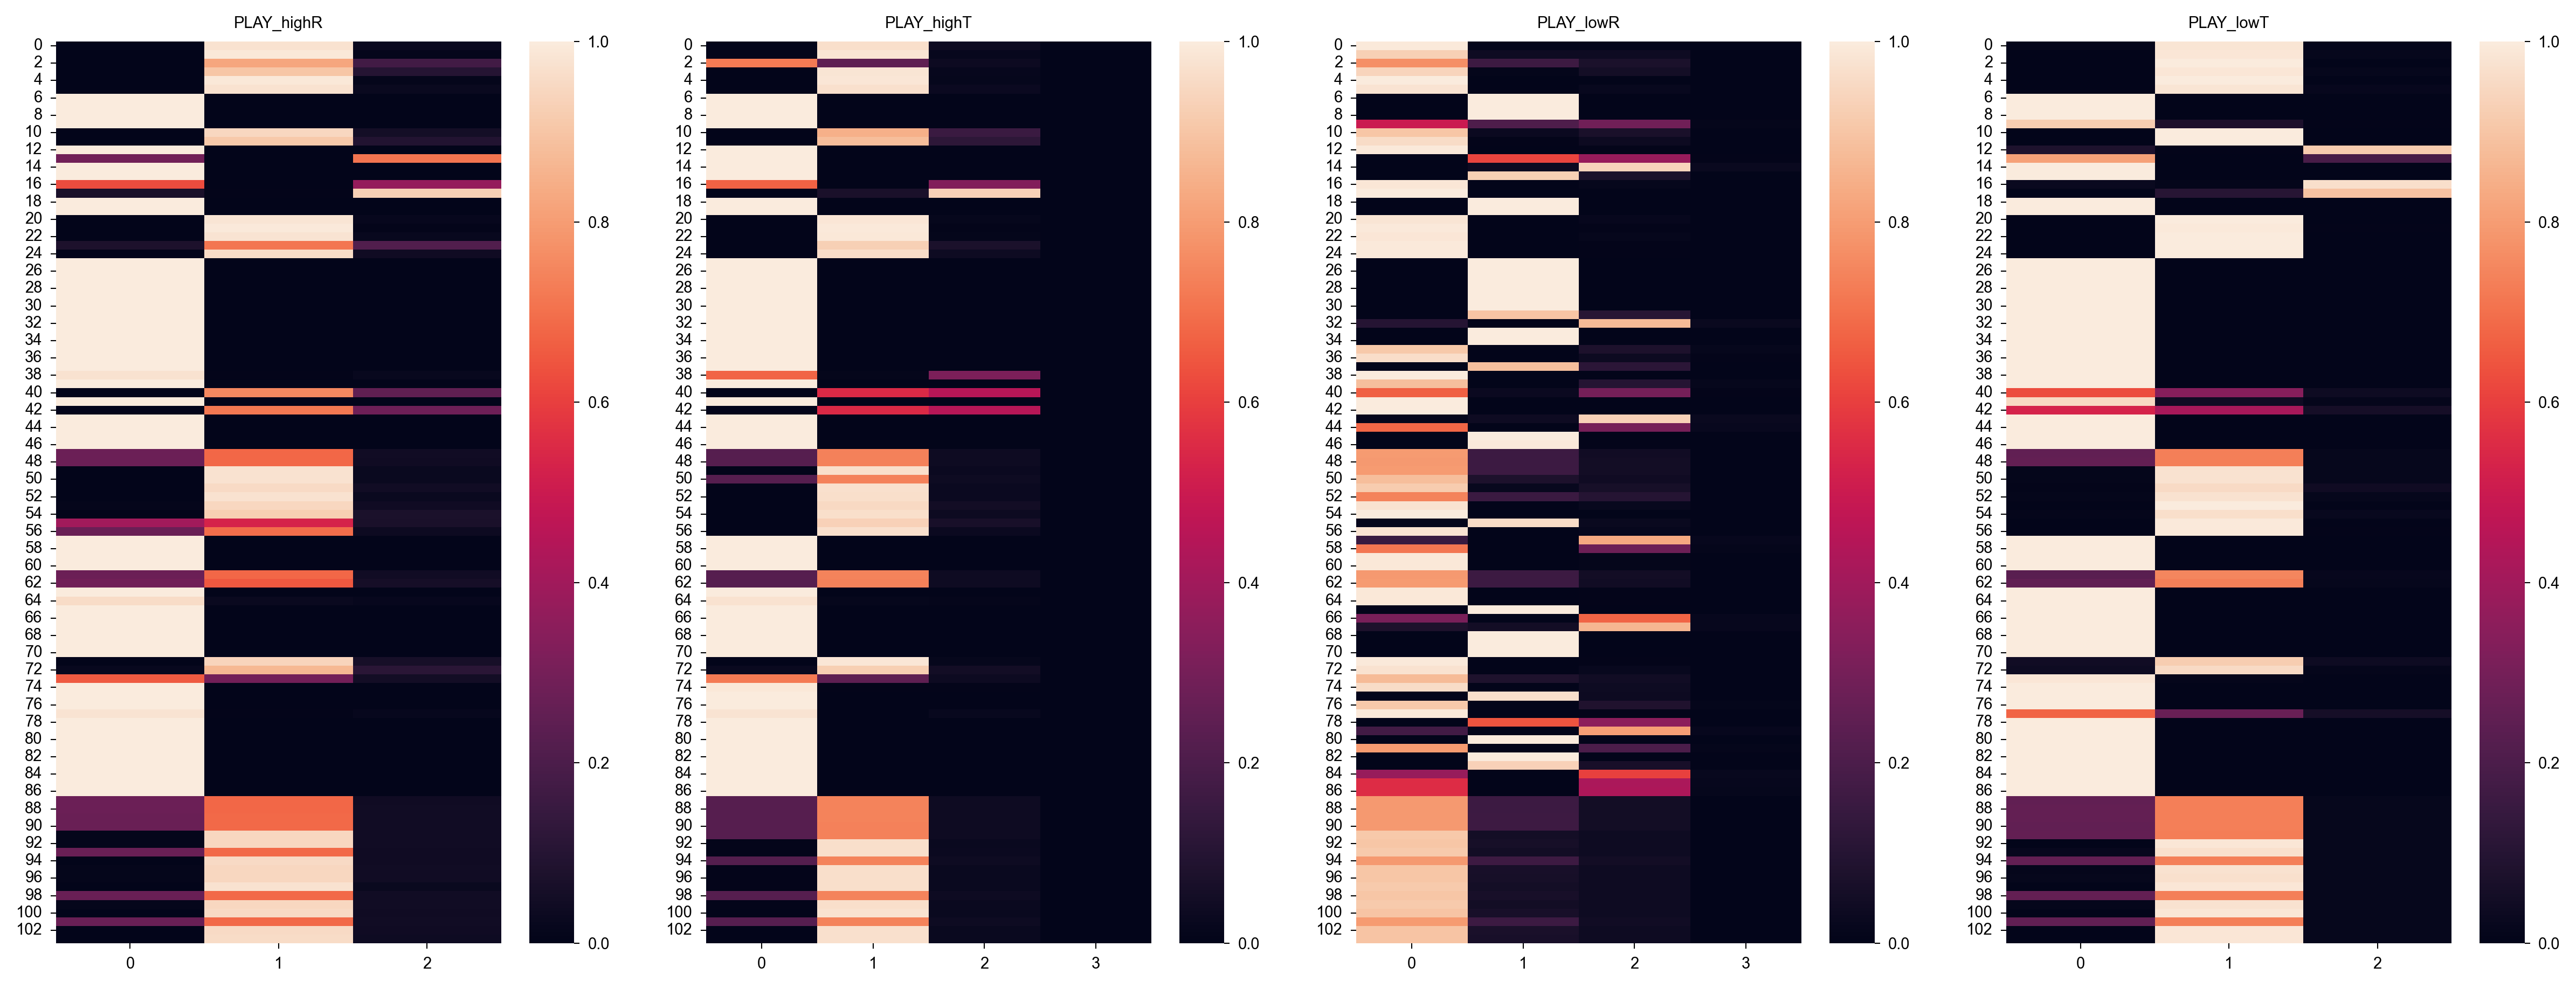

In [17]:
ncols = 4
nrows = 1
fig, axs = plt.subplots(nrows, ncols, figsize=(4*ncols, 6*nrows))
fig.tight_layout(h_pad=3, w_pad=3)
for idx, row in soft_df.iterrows():
    r, c = idx // ncols, idx % ncols
    ax = axs[r, c] if nrows > 1 else axs[c]
    sns.heatmap(row['soft_comm'], ax=ax)
    ax.set(title=f'{row["cond"]}')

In [18]:
def sample_partitions(args, indests_df):
    all_bs_df = []
    for idx, row in tqdm(indests_df.iterrows()):
        bs = random.sample(
            list(row['mode'].get_partitions().values()), 
            row['num_samples']
        )
        mode_ids = [idx]*len(bs)
        df = pd.DataFrame(dict(
            mode_id=mode_ids,
            b=bs,
        ))
        all_bs_df += [df]
        # all_bs += [
        #   row['mode'].sample_partition(MLE=True) 
        #   for _ in range(row['num_samples'])
        # ]
    all_bs_df = pd.concat(all_bs_df).reset_index(drop=True)
    return all_bs_df

def sample_nested_partitions(args, indests_df):
    all_bs_df = []
    for idx, row in tqdm(indests_df.iterrows()):
        bs = random.sample(
            list(row['mode'].get_nested_partitions().values()), 
            row['num_samples']
        )
        bs = [gt.nested_partition_clear_null(b) for b in bs]
        mode_ids = [idx]*len(bs)
        df = pd.DataFrame(dict(
            mode_id=mode_ids,
            b=bs,
        ))
        all_bs_df += [df]
        # all_bs += [
        #   row['mode'].sample_partition(MLE=True) 
        #   for _ in range(row['num_samples'])
        # ]
    all_bs_df = pd.concat(all_bs_df).reset_index(drop=True)
    return all_bs_df

In [19]:
# sample partitions per mode
args.total_samples = 1000
indests_df['num_samples'] = indests_df['omega'].apply(lambda x: np.round(x * args.total_samples).astype(int) if x > 0.01 else 1)
if args.sbm in ['m', 'a', 'd']:
    all_bs_df = sample_partitions(args, indests_df)
if args.sbm in ['h']:
    all_bs_df = sample_nested_partitions(args, indests_df)

0it [00:00, ?it/s]

47it [00:00, 269.20it/s]


In [20]:
# align all samples iteratively until the labels converge
pmode = gt.PartitionModeState(all_bs_df['b'], relabel=True, nested=args.nested, converge=False)
ent_diff = -np.inf
while ent_diff < 1e-10:
    ed = pmode.replace_partitions()
    print(ed)
    if np.isclose(ed, ent_diff, rtol=1e-10):
        break
    ent_diff = ed

-2.593390382709913
-8.782080840319395e-09
-8.782080840319395e-09


In [21]:
if args.sbm in ['m', 'a', 'd']:
    bs = pmode.get_partitions()
if args.sbm in ['h']:
    bs = pmode.get_nested_partitions()
bs = {k:v for k, v in sorted(bs.items())}
# bs = {k:v for k, v in (bs.items())}
all_bs_df['b_aligned'] = list(bs.values())

In [22]:
all_bs_df

,mode_id,b,b_aligned
0,0,"[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 2, 0, ...","[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 2, 1, ..."
1,0,"[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 2, 0, ...","[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 2, 1, ..."
2,0,"[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 2, 0, ...","[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 2, 1, ..."
3,0,"[1, 1, 2, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 2, 0, ...","[0, 0, 2, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 2, 1, ..."
4,0,"[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 2, 0, ...","[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 2, 1, ..."
...,...,...,...
3978,44,"[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 2, 0, ...","[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 2, 1, ..."
3979,44,"[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 2, 2, 0, ...","[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 2, 2, 1, ..."
3980,44,"[1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 2, 0, ...","[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 2, 1, ..."
3981,45,"[1, 1, 1, 2, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, ...","[0, 0, 0, 2, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, ..."


In [23]:
def get_pi_matrix(args, mrgnls):
    num_comms = np.max([len(mrgnl) for mrgnl in mrgnls])
    pi = np.zeros((len(mrgnls), num_comms))

    for idx_node, mrgnl in enumerate(mrgnls):
        mrgnl = np.array(mrgnl)
        pi[idx_node, np.where(mrgnl)[0]] = mrgnl[mrgnl > 0]

    pi = pi / np.expand_dims(pi.sum(axis=-1), axis=-1)
    return np.round(pi, decimals=3) # marginals matrix

In [24]:
if args.sbm in ['m', 'a', 'd']:
    pis_df = []
    for key, group in tqdm(all_bs_df.groupby(by='mode_id')):
        pm = gt.PartitionModeState(bs=group['b_aligned'], relabel=False, nested=args.nested, converge=False)
        mrgnls = pm.get_marginal(g)
        pi = get_pi_matrix(args, mrgnls)
        df = pd.DataFrame(dict(
            mode_id=[key],
            mode=[pm],
            pi=[pi],
        ))
        pis_df += [df]
        # break
    pis_df = pd.concat(pis_df).reset_index(drop=True)

100%|██████████| 47/47 [00:02<00:00, 16.13it/s]


In [25]:
def get_M(b):
    b = np.array(b).reshape(-1, 1)
    categories = np.arange(-1, np.max(b)+1).tolist() # first one indicating absence of comm. in the partition
    enc = OneHotEncoder(sparse_output=False, categories=[categories])
    M = enc.fit_transform(b)
    return M

def get_marginals(bs, level=0):
    all_Ms = []
    for bs_ in (bs):
        b = bs_[level]
        M = get_M(b)
        all_Ms.append(M)

    shapes = np.stack(list(zip(*[M.shape for M in all_Ms])), axis=-1)
    num_nodes, num_comms = np.max(shapes, axis=0)
    num_samples = len(all_Ms)

    Ms = np.zeros((num_nodes, num_comms, num_samples))
    for idx, M in enumerate(all_Ms):
        Ms[:M.shape[0], :M.shape[1], idx] = M

    rescale = lambda M: M / M.sum(axis=1, keepdims=True)

    M = np.mean(Ms, axis=-1) # frequencies
    M = M[:, 1:] # remove the absence indicating column
    M = rescale(M) # renormalize marginals to ensure we compute marginal whenever node is present in the partition
    M = np.nan_to_num(M)
    return M

def get_nested_marginals(bs, levels=[0, 1, 2]):
    Ms = []
    for level in levels:
        M = get_marginals(bs, level)
        Ms.append(M)
    return Ms

def project_level(Ms, level):
    # project level `level` onto level 0
    M_ = Ms[0]
    for l in range(1, level+1):
        M_ = M_ @ Ms[l]
    return M_

In [26]:
if args.sbm in ['h']:
    pis_df = []
    for key, group in tqdm(all_bs_df.groupby(by='mode_id')):
        pm = gt.PartitionModeState(
            bs=group['b_aligned'], 
            relabel=False, 
            nested=args.nested, 
            converge=False,
        )
        bs = list(pm.get_nested_partitions().values())
        
        levels=np.arange(np.max([len(bs_) for bs_ in bs]))
        Ms_ = get_nested_marginals(bs, levels)
        Ms = [project_level(Ms_, level) for level in levels]

        dct = {f'mode_id':[key]}
        dct[f'mode'] = [pm]
        for level, M in enumerate(Ms):
            dct[f'pi_{level}'] = [M]
        df = pd.DataFrame(dct)
        pis_df += [df]
        # break
    pis_df = pd.concat(pis_df).reset_index(drop=True)

In [27]:
# indests_df.merge(pis_df, on='mode_id', how='inner', suffixes=['', '_aligned'])
indests_df = pd.concat([indests_df, pis_df.add_suffix('_aligned')], axis=1)
indests_df

,cond,sbm,mode_id,mode,pi,omega,sigma,num_samples,mode_id_aligned,mode_aligned,pi_aligned
0,PLAY_highR,sbm--a,0,<graph_tool.inference.partition_modes.Partitio...,"[[0.0, 0.985516405961974, 0.014483594038026017...",0.253363,0.025277,253,0,<graph_tool.inference.partition_modes.Partitio...,"[[0.984, 0.0, 0.016], [1.0, 0.0, 0.0], [0.937,..."
1,PLAY_highR,sbm--a,1,<graph_tool.inference.partition_modes.Partitio...,"[[0.0, 0.9872134546711209, 0.01278654532887916...",0.115839,0.050446,116,1,<graph_tool.inference.partition_modes.Partitio...,"[[0.983, 0.0, 0.017], [1.0, 0.0, 0.0], [0.94, ..."
2,PLAY_highR,sbm--a,2,<graph_tool.inference.partition_modes.Partitio...,"[[0.0, 0.9685773904504725, 0.03142260954952743...",0.108714,0.044634,109,2,<graph_tool.inference.partition_modes.Partitio...,"[[0.945, 0.0, 0.055], [1.0, 0.0, 0.0], [0.734,..."
3,PLAY_highR,sbm--a,3,<graph_tool.inference.partition_modes.Partitio...,"[[0.0, 0.9896556239361005, 0.01034437606389943...",0.101908,0.034222,102,3,<graph_tool.inference.partition_modes.Partitio...,"[[1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [0.892, 0.0..."
4,PLAY_highR,sbm--a,4,<graph_tool.inference.partition_modes.Partitio...,"[[0.0, 0.9651193286126409, 0.03488067138735903...",0.101761,0.056444,102,4,<graph_tool.inference.partition_modes.Partitio...,"[[0.971, 0.0, 0.029], [0.99, 0.0, 0.01], [0.69..."
5,PLAY_highR,sbm--a,5,<graph_tool.inference.partition_modes.Partitio...,"[[0.0, 0.967537770518579, 0.03246222948142099]...",0.065359,0.091136,65,5,<graph_tool.inference.partition_modes.Partitio...,"[[0.969, 0.0, 0.031], [0.969, 0.0, 0.031], [0...."
6,PLAY_highR,sbm--a,6,<graph_tool.inference.partition_modes.Partitio...,"[[0.0, 0.9679778113968734, 0.03202218860312657...",0.052922,0.069693,53,6,<graph_tool.inference.partition_modes.Partitio...,"[[0.962, 0.0, 0.038], [0.981, 0.0, 0.019], [0...."
7,PLAY_highR,sbm--a,7,<graph_tool.inference.partition_modes.Partitio...,"[[0.0, 0.9867888918846051, 0.01321110811539498...",0.049493,0.059450,49,7,<graph_tool.inference.partition_modes.Partitio...,"[[0.98, 0.0, 0.02], [1.0, 0.0, 0.0], [0.959, 0..."
8,PLAY_highR,sbm--a,8,<graph_tool.inference.partition_modes.Partitio...,"[[0.0, 1.0], [0.0, 1.0], [0.003311258278145695...",0.036269,0.024997,36,8,<graph_tool.inference.partition_modes.Partitio...,"[[1.0, 0.0], [1.0, 0.0], [1.0, 0.0], [1.0, 0.0..."
9,PLAY_highR,sbm--a,9,<graph_tool.inference.partition_modes.Partitio...,"[[0.0, 0.938375350140056, 0.06162464985994398]...",0.023819,0.121897,24,9,<graph_tool.inference.partition_modes.Partitio...,"[[0.833, 0.0, 0.167], [0.958, 0.0, 0.042], [0...."


In [28]:
if args.sbm in ['m', 'a', 'd']:
    soft_aligned_df = []
    for cond, group in indests_df.groupby('cond'):
        M = get_membership_matrix(args, group, col=f'pi_aligned')
        omegas = group['omega'].to_list()
        X = np.average(M, axis=1, weights=omegas)
        soft_aligned_df += [pd.DataFrame(dict(
            cond=[cond],
            soft_comm=[X],
        ))]
    soft_aligned_df = pd.concat(soft_aligned_df).reset_index(drop=True)
    display(soft_aligned_df)

if args.sbm in ['h']:
    level = 0
    soft_aligned_df = []
    for cond, group in indests_df.groupby('cond'):
        M = get_membership_matrix(args, group, col=f'pi_{level}_aligned')
        omegas = group['omega'].to_list()
        X = np.average(M, axis=1, weights=omegas)
        soft_aligned_df += [pd.DataFrame(dict(
            cond=[cond],
            soft_comm=[X],
        ))]
    soft_aligned_df = pd.concat(soft_aligned_df).reset_index(drop=True)
    display(soft_aligned_df)

,cond,soft_comm
0,PLAY_highR,"[[0.9711130637843608, 0.0, 0.02888693621563918..."
1,PLAY_highT,"[[0.9723690276110443, 0.0, 0.02763097238895558..."
2,PLAY_lowR,"[[0.9942244448889778, 0.0, 0.00577555511102220..."
3,PLAY_lowT,"[[0.983967273454691, 0.009964859638594389, 0.0..."


IndexError: index 2 is out of bounds for axis 0 with size 2

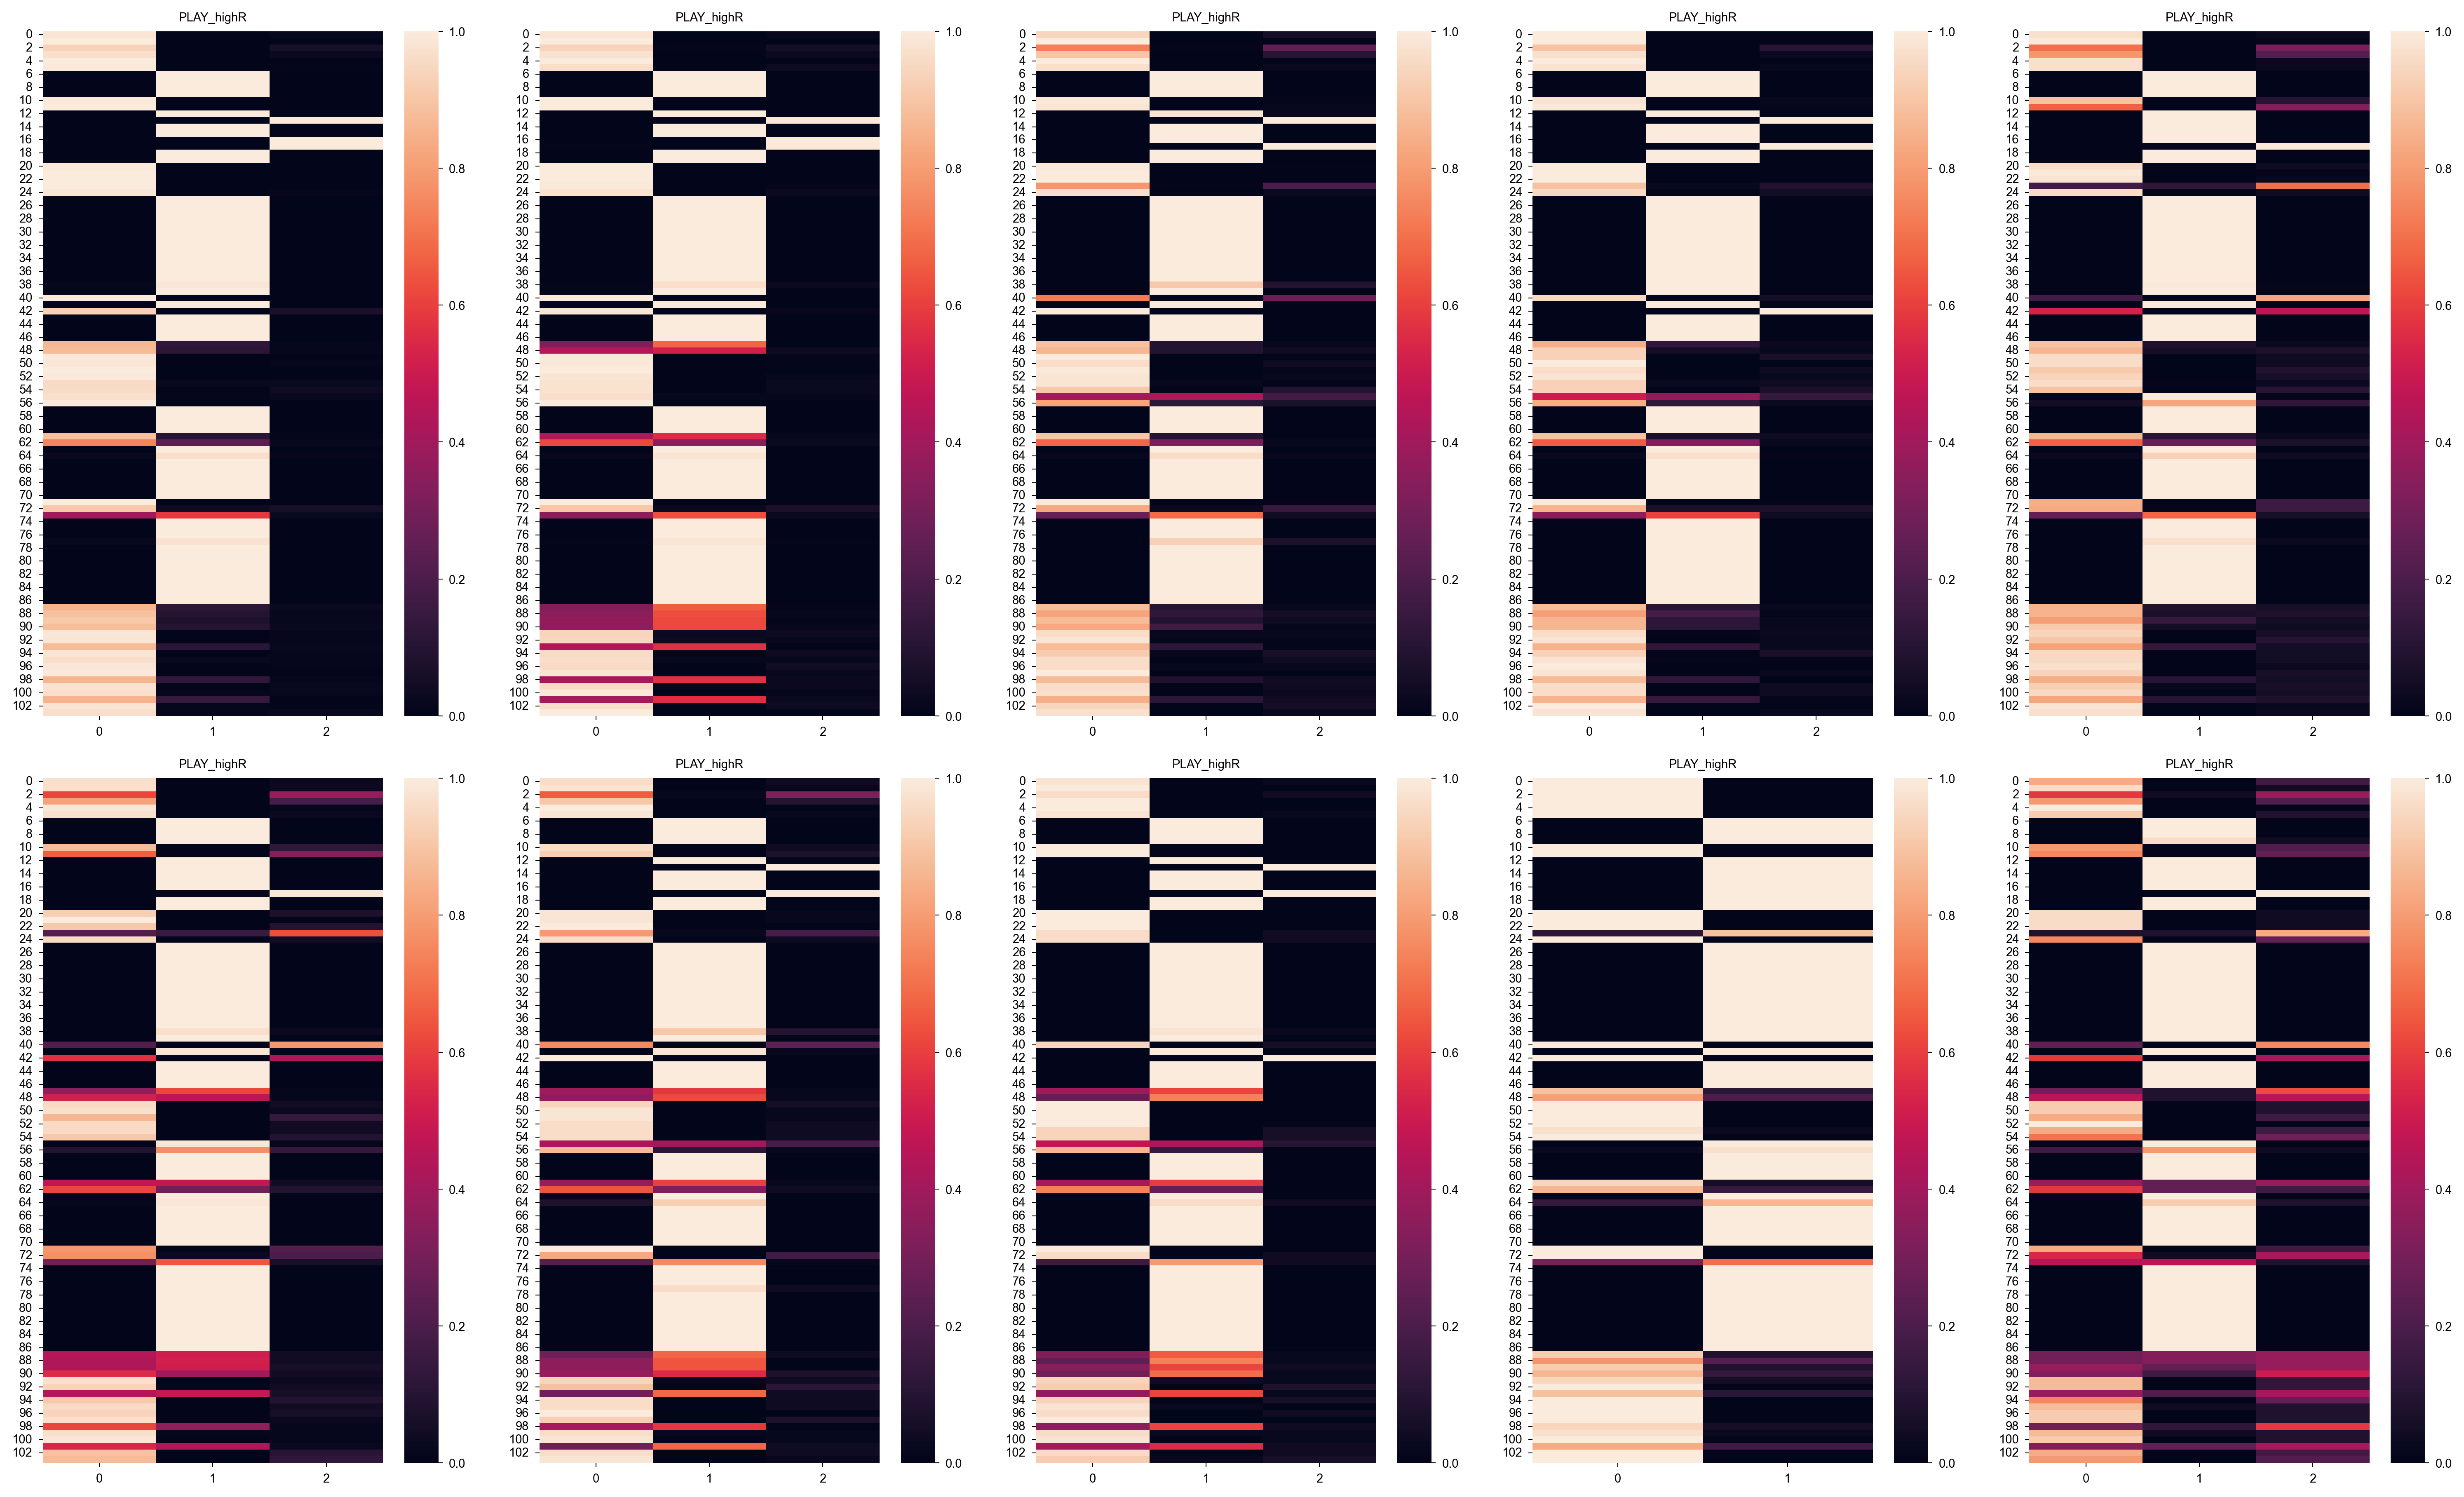

In [29]:
ncols = 5
nrows = 2
fig, axs = plt.subplots(nrows, ncols, figsize=(4*ncols, 6*nrows))
fig.tight_layout(h_pad=3, w_pad=3)
# X = soft_aligned_df.iloc[0]['soft_comm']
for idx, row in indests_df.iterrows():
    r, c = idx // ncols, idx % ncols
    ax = axs[r, c] if nrows > 1 else axs[c]
    if args.sbm in ['h']:
        sns.heatmap(row['pi_0_aligned'], ax=ax)
    else:
        sns.heatmap(row['pi_aligned'], ax=ax)
    ax.set(title=f'{row["cond"]}')

[Text(0.5, 1.0, 'group'),
 Text(0.5, 29.333333333333318, 'comm'),
 Text(-13.416666666666671, 0.5, 'roi')]

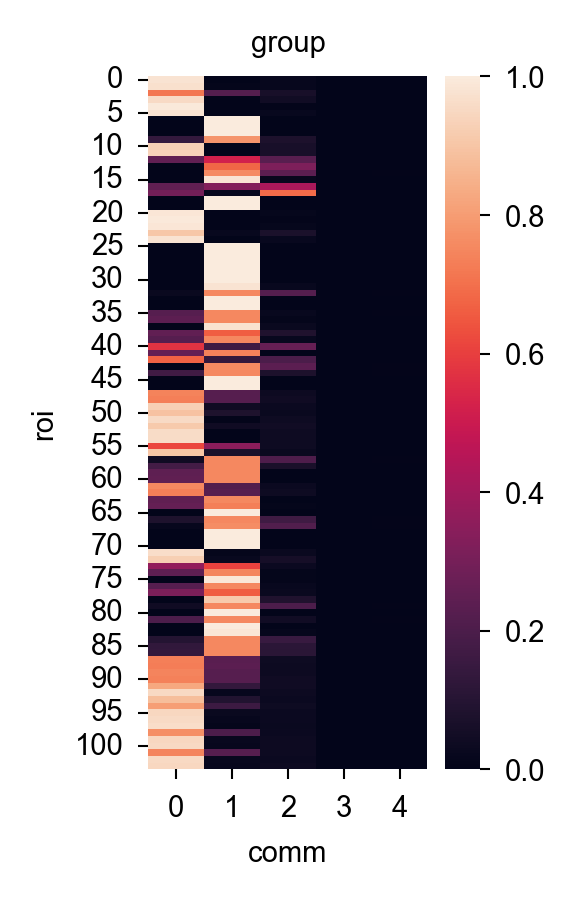

In [30]:
SCsA = get_membership_matrix(args, soft_aligned_df, col='soft_comm') # soft comms aligned
group_soft_comm = np.mean(SCsA, axis=1)
# group_soft_comm = np.median(SCsA, axis=1) # robust to outliers

fig, axs = plt.subplots(1, 1, figsize=(1.5, 3))
ax = axs
sns.heatmap(group_soft_comm, ax=ax)
ax.set(title=f'group', xlabel=f'comm', ylabel=f'roi')

In [31]:
# SAVE THE ALIGNED MODES AND MARGINALS

In [32]:
if args.sbm in ['m', 'a', 'd']:
    for cond, group in indests_df.groupby('cond'):
        out_folder = f'{ESTIM_path}/{SBM}/cond-{cond}/partition-modes-group-aligned'
        os.makedirs(f'{out_folder}', exist_ok=True)
        
        cols = ['cond', 'sbm', 'mode_aligned', 'omega']
        with open(f'{out_folder}/desc-modes.pkl', 'wb') as f:
            pickle.dump(group[cols], f)
            
        cols = ['cond', 'sbm', 'pi_aligned', 'omega']
        with open(f'{out_folder}/desc-mem-mats.pkl', 'wb') as f:
            pickle.dump(group[cols], f)
        # break

In [33]:
if args.sbm in ['h']:
    for cond, group in indests_df.groupby('cond'):
        out_folder = f'{ESTIM_path}/{SBM}/cond-{cond}/partition-modes-group-aligned'
        os.makedirs(f'{out_folder}', exist_ok=True)

        cols = ['cond', 'sbm'] +[col for col in list(group.columns) if 'mode_' in col if 'mode_id' not in col] + ['omega']
        with open(f'{out_folder}/desc-modes.pkl', 'wb') as f:
            pickle.dump(group[cols], f)

        cols = ['cond', 'sbm'] +[col for col in list(group.columns) if 'pi_' in col if 'mode_id' not in col] + ['omega']
        with open(f'{out_folder}/desc-mem-mats.pkl', 'wb') as f:
            pickle.dump(group[cols], f)

        # break